# Use this notebook to diagonalise 3D Hamiltonian

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy import sparse
from scipy.optimize import minimize_scalar

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer

## Trap parameters:

In [22]:
initial_power = 7000* si.uW
initial_waist = 0.71*si.uW
initial_distance = 0.808*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    m= 161 * const.value("atomic mass constant"),
    a_s= 85* const.value("Bohr radius"),
    mu_b= 9.93 * const.value("Bohr magneton" ),
    a= 180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

omega_z1 = sp.sqrt(4*trap.power_tweezer1*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer1**3
omega_z2 = sp.sqrt(4*trap.power_tweezer2*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer2**3

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer2**2

print(f"omega_r1: {float(trap.subs(omega_r1)/2/np.pi):.1f}Hz, omega_r2: {float(trap.subs(omega_r2)/2/np.pi):.1f}Hz")
print(f"omega_z1: {float(trap.subs(omega_z1)/2/np.pi):.1f}Hz, omega_z2: {float(trap.subs(omega_z2)/2/np.pi):.1f}Hz")

omega_r1: 60954.0Hz, omega_r2: 60954.0Hz
omega_z1: 10279.9Hz, omega_z2: 10279.9Hz


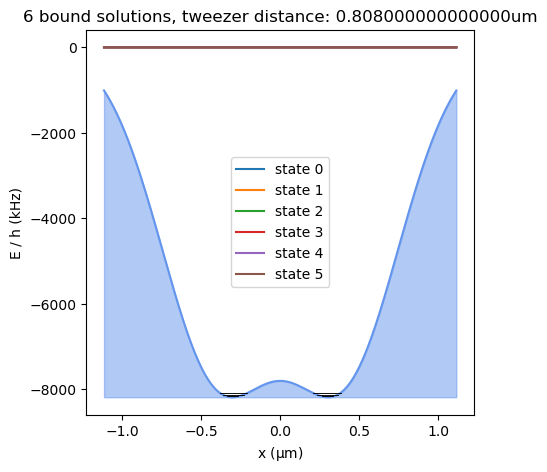

In [23]:
left_cutoff = -0.5*float(trap.subs(trap.distance_tweezers))-1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*float(trap.subs(trap.distance_tweezers))+1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])


# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.x, (left_cutoff, right_cutoff), 500, k=6
)

# States that are below the potential barrier
bound_states = energies < potential(left_cutoff)


z_np = np.linspace(left_cutoff, right_cutoff, num=500)
ax: plt.Axes
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz,color="cornflowerblue" ,marker="None")

ax.set_title(f"{np.sum(bound_states)} bound solutions, tweezer distance: {trap.subs(trap.distance_tweezers)/si.um}um")
ax.set_xlabel(r"x ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")
abs_min = np.min(potential(z_np))
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    alpha=0.5,
    color="cornflowerblue"
)

count = 0
for i, bound in enumerate(bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    ax.plot(z_np/si.um, state *1e1, marker="None",label=f"state {count}")#, c="k")
    count += 1

plt.legend()
plt.show()

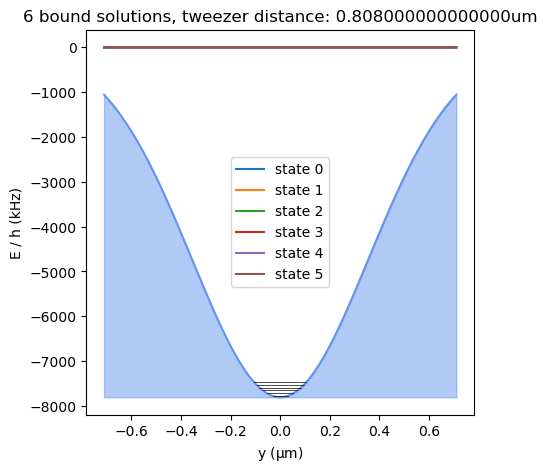

In [24]:
left_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])


# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.y, (left_cutoff, right_cutoff), 500, k=6
)

# States that are below the potential barrier
bound_states = energies < potential(left_cutoff)


z_np = np.linspace(left_cutoff, right_cutoff, num=500)
ax: plt.Axes
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz,color="cornflowerblue" ,marker="None")

ax.set_title(f"{np.sum(bound_states)} bound solutions, tweezer distance: {trap.subs(trap.distance_tweezers)/si.um}um")
ax.set_xlabel(r"y ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")
abs_min = np.min(potential(z_np))
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    alpha=0.5,
    color="cornflowerblue"
)

count = 0
for i, bound in enumerate(bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    ax.plot(z_np/si.um, state *1e1, marker="None",label=f"state {count}")#, c="k")
    count += 1

plt.legend()
plt.show()

C:\Users\naeve\AppData\Local\Temp\ipykernel_13056\2474033355.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


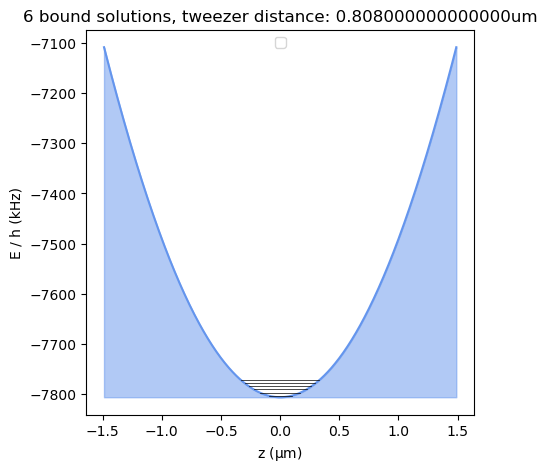

In [25]:
left_cutoff = -0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
right_cutoff = 0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])


# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.z, (left_cutoff, right_cutoff), 500, k=6
)

# States that are below the potential barrier
bound_states = energies < potential(left_cutoff)


z_np = np.linspace(left_cutoff, right_cutoff, num=500)
ax: plt.Axes
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz,color="cornflowerblue" ,marker="None")

ax.set_title(f"{np.sum(bound_states)} bound solutions, tweezer distance: {trap.subs(trap.distance_tweezers)/si.um}um")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")
abs_min = np.min(potential(z_np))
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    alpha=0.5,
    color="cornflowerblue"
)

count = 0
for i, bound in enumerate(bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    #ax.plot(z_np/si.um, state *1e1, marker="None",label=f"state {count}")#, c="k")
    count += 1

plt.legend()
plt.show()

In [26]:
V = trap.subs(trap.get_potential(apply_zero_offset=False))
a = float(trap.subs(trap.distance_tweezers))

#find minima of potential
def V_func(x):
    return float(V.subs({trap.x:x, trap.y:0, trap.z:0}))

x_right = minimize_scalar(V_func,bracket=[0,a]).x
x_left = minimize_scalar(V_func,bracket=[-a,0]).x

#catch case where both potentials have already merged
tunneling_dist = abs(x_right-x_left)
if tunneling_dist < 1e-15:
    raise Exception("potential has only one minmum")

#depts of both tweezers
V_1 = abs(V_func(x_left) - V_func(0))
V_2 = abs(V_func(x_right) - V_func(0)) 

#trapping frequencies
omega_x1, omega_x2 = trap.get_both_omega(trap.x)
omega_y1, omega_y2 = trap.get_both_omega(trap.y)
omega_z1, omega_z2 = trap.get_both_omega(trap.z)

#recoil energy
E_r = const.h**2/(8*trap.m*trap.distance_tweezers**2)

#print results
print(f"depth 1: {V_1/const.k /si.uK:.4f} uK")
print(f"depth 2: {V_2/const.k /si.uK:.4f} uK")
print(f"estimated tilt: {abs(V_1 - V_2)/const.h:.2f} Hz")

print(f"trapping frequency x 1: {trap.subs(omega_x1)/2/np.pi:.2f} Hz")
print(f"trapping frequency x 2: {trap.subs(omega_x2)/2/np.pi:.2f} Hz")
print(f"trapping frequency y 1: {trap.subs(omega_y1)/2/np.pi:.2f} Hz")
print(f"trapping frequency y 2: {trap.subs(omega_y2)/2/np.pi:.2f} Hz")
print(f"trapping frequency z 1: {trap.subs(omega_z1)/2/np.pi:.2f} Hz")
print(f"trapping frequency z 2: {trap.subs(omega_z2)/2/np.pi:.2f} Hz")

print(f"tunneling distance: {tunneling_dist/si.nm:.2f} um")

depth 1: 18.3716 uK
depth 2: 18.3716 uK
estimated tilt: 0.00 Hz
trapping frequency x 1: 41891.68 Hz
trapping frequency x 2: 41891.68 Hz
trapping frequency y 1: 63870.24 Hz
trapping frequency y 2: 63870.24 Hz
trapping frequency z 1: 9108.96 Hz
trapping frequency z 2: 9108.96 Hz
tunneling distance: 604.67 um


## Diagonalisation parameters

In [ ]:
distances = [808*si.nm ]

for i, dist in enumerate(distances):

        trap[trap.distance_tweezers] = dist

        n_grid_1D = 100  

        n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
        n_levels = 6

        left_cutoff = -0.5*initial_distance-1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        right_cutoff = 0.5*initial_distance+1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        back_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        front_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        bottom_cutoff = -0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
        top_cutoff = 0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

        extend = [(left_cutoff,right_cutoff),
                (back_cutoff,front_cutoff),
                (bottom_cutoff,top_cutoff)]

        try:
                # Solve the hamiltonian numerically
                energies, states, potential, coords = trap.nstationary_solution(
                        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
                        method="matrix_free", export=True)
        except:
                continue

        x = coords[trap.x]
        y = coords[trap.y]
        z = coords[trap.z]
        x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
        pot = potential(x3D,y3D,z3D)

In [27]:
distances = np.linspace(730,850,10)*si.nm

for i, dist in enumerate(distances):

        trap[trap.distance_tweezers] = dist

        n_grid_1D = 100  

        n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
        n_levels = 6

        left_cutoff = -0.5*initial_distance-1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        right_cutoff = 0.5*initial_distance+1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        back_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        front_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
        bottom_cutoff = -0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
        top_cutoff = 0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

        extend = [(left_cutoff,right_cutoff),
                (back_cutoff,front_cutoff),
                (bottom_cutoff,top_cutoff)]

        try:
                # Solve the hamiltonian numerically
                energies, states, potential, coords = trap.nstationary_solution(
                        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
                        method="matrix_free", export=True)
        except:
                continue

        x = coords[trap.x]
        y = coords[trap.y]
        z = coords[trap.z]
        x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
        pot = potential(x3D,y3D,z3D)

files saved with ...._2025-03-31_16-07-07
files saved with ...._2025-03-31_17-02-40
files saved with ...._2025-03-31_17-56-25
files saved with ...._2025-03-31_18-46-11
files saved with ...._2025-03-31_19-34-16
files saved with ...._2025-03-31_20-21-21
files saved with ...._2025-03-31_21-07-40
files saved with ...._2025-03-31_21-53-18
files saved with ...._2025-03-31_22-38-09
files saved with ...._2025-03-31_23-21-53


## Visualise results

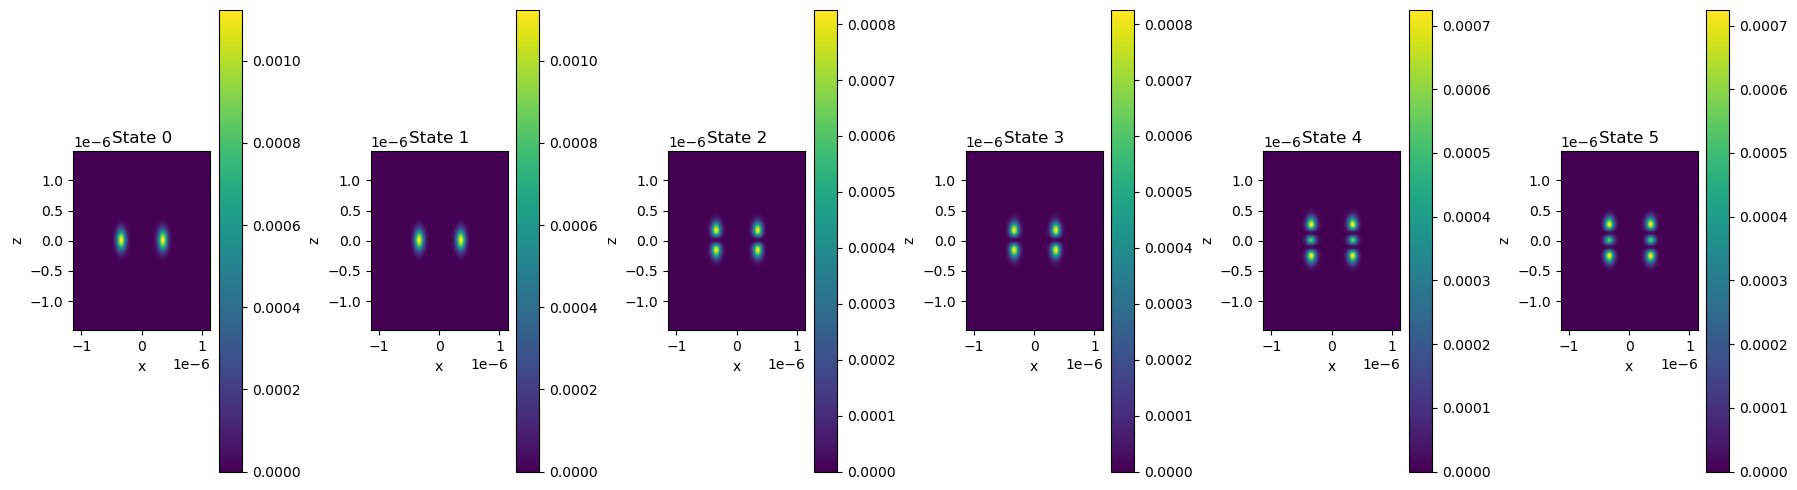

In [ ]:
n_states = 6

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
